Business often spends money to acquire new customers. It is importance to tackle problem of churn out which hurt business

In [1]:
from __future__ import division
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.cluster import KMeans



In [3]:
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [40]:
df= pd.read_csv('./Downloads/data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [13]:
df.loc[df.Churn=='No','Churn'] = 0 
df.loc[df.Churn=='Yes','Churn'] = 1
df.groupby('gender').Churn.sum()/df.shape[0]

gender
Female    0.133324
Male      0.132046
Name: Churn, dtype: float64

In [15]:
df.tenure.describe()

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

In [16]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


/Users/tridoan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/tridoan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/tridoan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

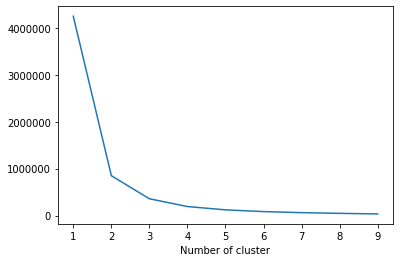

In [18]:
sse={}
df_cluster = df[['tenure']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [19]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df[['tenure']])
df['TenureCluster'] = kmeans.predict(df[['tenure']])

In [21]:
df = order_cluster('TenureCluster', 'tenure',df,True)
df.groupby('TenureCluster').tenure.describe()

,count,mean,std,min,25%,50%,75%,max
TenureCluster,,,,,,,,
0,2941.0,7.801428,6.227163,0.0,2.0,6.0,13.0,21.0
1,1863.0,34.288782,7.992701,22.0,27.0,34.0,41.0,48.0
2,2239.0,63.048682,7.478229,49.0,56.0,64.0,70.0,72.0


In [22]:
df['TenureCluster'] = df["TenureCluster"].replace({0:'Low',1:'Mid',2:'High'})

/Users/tridoan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/tridoan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/tridoan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

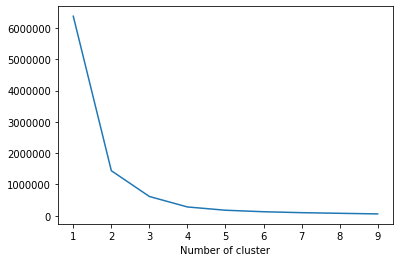

In [23]:
sse={}
df_cluster = df[['MonthlyCharges']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [24]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df[['MonthlyCharges']])
df['MonthlyChargeCluster'] = kmeans.predict(df[['MonthlyCharges']])

df = order_cluster('MonthlyChargeCluster', 'MonthlyCharges',df,True)
df.groupby('MonthlyChargeCluster').MonthlyCharges.describe()

,count,mean,std,min,25%,50%,75%,max
MonthlyChargeCluster,,,,,,,,
0,1892.0,23.384619,5.660437,18.25,19.80,20.40,25.0500,42.40
1,2239.0,61.628808,10.441432,42.60,51.80,61.55,70.7000,77.80
2,2912.0,94.054258,10.343944,77.85,85.05,93.90,101.9125,118.75


In [25]:
df['MonthlyChargeCluster'] = df["MonthlyChargeCluster"].replace({0:'Low',1:'Mid',2:'High'})

In [26]:
df[pd.to_numeric(df['TotalCharges'], errors='coerce').isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TenureCluster,MonthlyChargeCluster
92,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,Two year,No,Mailed check,20.25,,0,Low,Low
138,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,Two year,No,Mailed check,25.75,,0,Low,Low
425,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,Two year,No,Mailed check,19.85,,0,Low,Low
488,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,Two year,No,Mailed check,25.35,,0,Low,Low
566,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,Two year,No,Mailed check,20.00,,0,Low,Low
681,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0,Low,Low
1977,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0,Low,Mid
2116,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,No,Two year,No,Credit card (automatic),56.05,,0,Low,Mid
3016,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,No,Two year,No,Mailed check,73.35,,0,Low,Mid
3029,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,...,No,No,Two year,Yes,Bank transfer (automatic),61.90,,0,Low,Mid


In [27]:
len(df[pd.to_numeric(df['TotalCharges'], errors='coerce').isnull()])

11

In [28]:
df.loc[pd.to_numeric(df['TotalCharges'], errors='coerce').isnull(),'TotalCharges'] = np.nan
df = df.dropna()

In [29]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



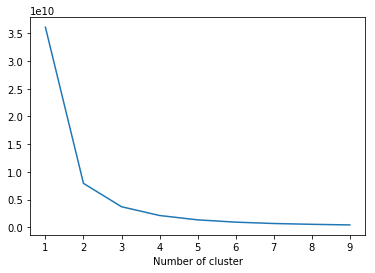

In [46]:
sse={}
df_cluster = df_data[['TotalCharges']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [30]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df[['TotalCharges']])
df['TotalChargeCluster'] = kmeans.predict(df[['TotalCharges']])

In [31]:
df = order_cluster('TotalChargeCluster', 'TotalCharges',df,True)
df.groupby('TotalChargeCluster').TotalCharges.describe()

,count,mean,std,min,25%,50%,75%,max
TotalChargeCluster,,,,,,,,
0,4165.0,687.758896,573.438799,18.80,161.6500,537.35,1144.600,1983.15
1,1612.0,3280.360205,814.669932,1985.15,2553.6125,3218.70,3974.950,4786.15
2,1255.0,6297.778685,1001.345310,4793.80,5478.0750,6151.90,7044.175,8684.80


In [32]:
df['TotalChargeCluster'] = df["TotalChargeCluster"].replace({0:'Low',1:'Mid',2:'High'})

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customerID            7032 non-null   object 
 1   gender                7032 non-null   object 
 2   SeniorCitizen         7032 non-null   int64  
 3   Partner               7032 non-null   object 
 4   Dependents            7032 non-null   object 
 5   tenure                7032 non-null   int64  
 6   PhoneService          7032 non-null   object 
 7   MultipleLines         7032 non-null   object 
 8   InternetService       7032 non-null   object 
 9   OnlineSecurity        7032 non-null   object 
 10  OnlineBackup          7032 non-null   object 
 11  DeviceProtection      7032 non-null   object 
 12  TechSupport           7032 non-null   object 
 13  StreamingTV           7032 non-null   object 
 14  StreamingMovies       7032 non-null   object 
 15  Contract             

In [34]:
#import Label Encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dummy_columns = [] #array for multiple value columns

for column in df.columns:
    if df[column].dtype == object and column != 'customerID':
        if df[column].nunique() == 2:
            #apply Label Encoder for binary ones
            df[column] = le.fit_transform(df[column]) 
        else:
            dummy_columns.append(column)

#apply get dummies for selected columns
df = pd.get_dummies(data = df,columns = dummy_columns)

In [35]:
df[['gender','Partner','TenureCluster_High','TenureCluster_Low','TenureCluster_Mid']].head()

,gender,Partner,TenureCluster_High,TenureCluster_Low,TenureCluster_Mid
0,0,1,0,1,0
1,0,0,0,1,0
2,1,0,0,1,0
3,1,0,0,1,0
4,1,1,0,1,0


In [38]:
all_columns = []
for column in df_data.columns:
    column = column.replace(" ", "_").replace("(", "_").replace(")", "_").replace("-", "_")
    all_columns.append(column)

df.columns = all_columns

ValueError: Length mismatch: Expected axis has 51 elements, new values have 22 elements

In [37]:
glm_columns = 'gender'

for column in df.columns:
    if column not in ['Churn','customerID','gender']:
        glm_columns = glm_columns + ' + ' + column

In [61]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
 

glm_model = smf.glm(formula='Churn ~ {}'.format(glm_columns), data=df_data, family=sm.families.Binomial())
res = glm_model.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Churn   No. Observations:                 7032
Model:                            GLM   Df Residuals:                     7002
Model Family:                Binomial   Df Model:                           29
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2902.2
Date:                Sat, 25 May 2019   Deviance:                       5804.5
Time:                        15:50:33   Pearson chi2:                 7.60e+03
No. Iterations:                   100   Covariance Type:             nonrobust
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   0.2555      0.276      0.924 

In [62]:
np.exp(res.params)

Intercept                                  1.291094
gender                                     0.976998
SeniorCitizen                              1.247633
Partner                                    1.001130
Dependents                                 0.877318
tenure                                     0.939874
PhoneService                               1.261550
PaperlessBilling                           1.412110
MonthlyCharges                             0.966097
TotalCharges                               1.000115
MultipleLines_No                           0.892446
MultipleLines_No_phone_service             1.023419
MultipleLines_Yes                          1.413587
InternetService_DSL                        0.546815
InternetService_Fiber_optic                2.873624
InternetService_No                         0.821650
OnlineSecurity_No                          1.389280
OnlineSecurity_No_internet_service         0.821650
OnlineSecurity_Yes                         1.131047
OnlineBackup

In [63]:
#create feature set and labels
X = df_data.drop(['Churn','customerID'],axis=1)
y = df_data.Churn

In [64]:
#train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

In [65]:
#building the model
xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.84
Accuracy of XGB classifier on test set: 0.81


In [67]:
y_pred = xgb_model.predict(X_test)

In [69]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88       266
           1       0.67      0.45      0.54        86

   micro avg       0.81      0.81      0.81       352
   macro avg       0.76      0.69      0.71       352
weighted avg       0.80      0.81      0.80       352



In [ ]:
from xgboost import plot_tree

##set up the parameters
fig, ax = plt.subplots(figsize=(100,100))
plot_tree(xgb_model, ax=ax)

In [ ]:
1/(1+np.exp(-0.032))


In [70]:
from xgboost import plot_importance

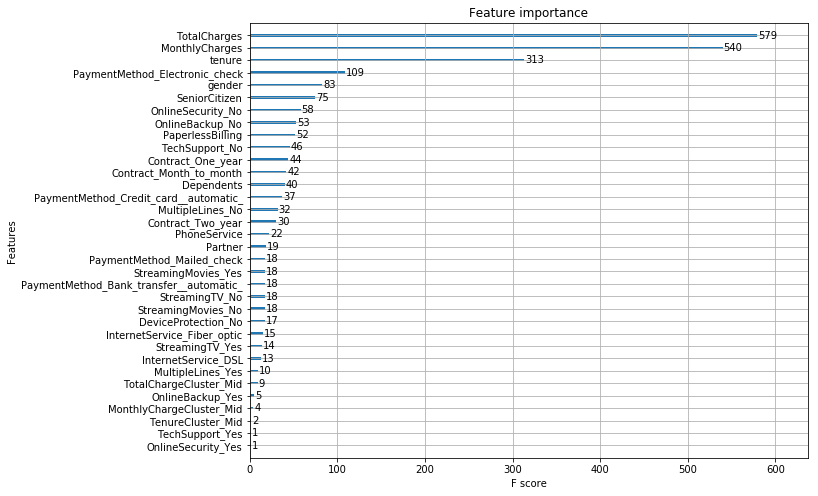

In [71]:
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xgb_model, ax=ax)

In [72]:
df_data['proba'] = xgb_model.predict_proba(df_data[X_train.columns])[:,1]

In [74]:
df_data[['customerID', 'proba']].head()

,customerID,proba
0,7590-VHVEG,0.514636
1,6713-OKOMC,0.144643
2,7469-LKBCI,0.017225
3,8779-QRDMV,0.913855
4,1680-VDCWW,0.044838
